# BundleFlow Colab Demo

**🎯 Rectified Flow–based menus for combinatorial auctions**

このノートブックでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化をデモンストレーションします。

## 📋 目次
1. [環境セットアップ](#setup)
2. [新しいAPI構造のデモ](#api-demo)
3. [Stage1: Flow初期化](#stage1)
4. [Stage2: Menu最適化](#stage2)
5. [結果の可視化](#visualization)

---


In [52]:
# 日本語フォントの設定（グラフで日本語を表示するため）
import matplotlib.pyplot as plt
import matplotlib

# 日本語フォントの設定（複数のフォントを試す）
matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
matplotlib.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策

print("✅ 日本語フォント設定完了")


✅ 日本語フォント設定完了


## 1. 環境セットアップ

まず、GPU環境を確認し、必要なパッケージをインストールします。


In [25]:
# GPU環境確認
!nvidia-smi

Sun Oct 12 12:47:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             55W /  400W |     871MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [26]:
# 必要なパッケージのインストール
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install omegaconf tqdm numpy matplotlib seaborn


Looking in indexes: https://download.pytorch.org/whl/cu121


In [27]:
# PyTorchとCUDAの確認
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB


In [28]:
# colabのみ実行
%cd /content/bundle-flow
import sys
sys.path.append('/content/bundle-flow/bundleflow')

/content/bundle-flow


## 2. デモ

BundleFlowを紹介します。


In [29]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BundleFlowの新しいAPI
from bundleflow.models.flow import BundleFlow
from bundleflow.models.menu import MenuElement, Mechanism
from bundleflow.valuation.valuation import XORValuation

print("✅ 新しいAPI構造のインポートが完了しました")
print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


✅ 新しいAPI構造のインポートが完了しました
PyTorch device: cuda


In [30]:
# 基本的なAPIのデモンストレーション
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. BundleFlow（速度場ネットワーク）の作成
m = 10  # 商品数
flow = BundleFlow(m=m).to(device)
print(f"✅ BundleFlow created with m={m}")

# 2. 速度場の計算
x = torch.randn(3, m, device=device)
t = torch.rand(3, device=device)
v = flow.velocity(x, t)
print(f"✅ Velocity field shape: {v.shape}")

# 3. MenuElement（メニュー要素）の作成
D = 5  # 初期分布の混合成分数
elem = MenuElement(m=m, D=D).to(device)
price = elem.price()
print(f"✅ MenuElement created with price: {price.detach().item():.4f}")

# 4. XORValuation（評価関数）の作成
atoms = [([1, 2, 3], 5.0), ([4, 5], 3.0), ([6, 7, 8, 9], 8.0)]
valuation = XORValuation.from_bundle_list(m, atoms)
bundle = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0])
value = valuation.value(bundle)
print(f"✅ XORValuation value: {value:.4f}")


Using device: cuda
✅ BundleFlow created with m=10
✅ Velocity field shape: torch.Size([3, 10])
✅ MenuElement created with price: 0.1111
✅ XORValuation value: 8.0000


## 3. Stage1: Flow初期化

速度場ネットワークを学習して、連続変数から離散束への変換を学習します。


In [32]:
# Stage1の設定（小規模でデモ用）
stage1_config = {
    'm': 10,           # 商品数（小規模）
    'D': 4,           # 混合成分数
    'iters': 20000,    # イテレーション数（デモ用に短縮）
    'batch': 512,     # バッチサイズ
    'lr': 5e-4,       # 学習率
    'sigma_z': 0.05,  # ノイズ標準偏差
    'ode_steps': 50,  # ODE積分ステップ数
    'seed': 42
}

print("Stage1設定:")
for key, value in stage1_config.items():
    print(f"  {key}: {value}")


Stage1設定:
  m: 10
  D: 4
  iters: 20000
  batch: 512
  lr: 0.0005
  sigma_z: 0.05
  ode_steps: 50
  seed: 42


In [33]:
# Stage1学習の実行
import random
import time
from torch import optim

# 乱数固定
random.seed(stage1_config['seed'])
torch.manual_seed(stage1_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage1_config['seed'])

# フローモデルの作成
flow = BundleFlow(m=stage1_config['m']).to(device)
optimizer = optim.Adam(flow.parameters(), lr=stage1_config['lr'])

# 初期分布（混合Gaussian）
mus = torch.empty(stage1_config['D'], stage1_config['m'], device=device).uniform_(-0.2, 1.2)
sigmas = torch.full((stage1_config['D'],), 0.5, device=device)
weights = torch.full((stage1_config['D'],), 1.0 / stage1_config['D'], device=device)

print(f"🚀 Stage1学習開始 (device: {device})")
print(f"モデルパラメータ数: {sum(p.numel() for p in flow.parameters()):,}")

# 学習ループ
losses = []
start_time = time.time()

for it in range(1, stage1_config['iters'] + 1):
    # Rectified Flow損失の計算
    loss = flow.rectified_flow_loss(
        B=stage1_config['batch'],
        mus=mus, sigmas=sigmas, weights=weights,
        sigma_z=stage1_config['sigma_z']
    )

    # 最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().item())

    # 進捗表示
    if it % 100 == 0:
        elapsed = time.time() - start_time
        print(f"[{it}/{stage1_config['iters']}] Loss: {loss.detach().item():.6f} Time: {elapsed:.1f}s")

print(f"✅ Stage1学習完了! 最終損失: {losses[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")


🚀 Stage1学習開始 (device: cuda)
モデルパラメータ数: 51,685
[100/20000] Loss: 1.315420 Time: 0.6s
[200/20000] Loss: 1.269985 Time: 1.2s
[300/20000] Loss: 1.279171 Time: 1.8s
[400/20000] Loss: 1.252921 Time: 2.4s
[500/20000] Loss: 1.232625 Time: 3.0s
[600/20000] Loss: 1.223528 Time: 3.6s
[700/20000] Loss: 1.228092 Time: 4.1s
[800/20000] Loss: 1.242330 Time: 4.6s
[900/20000] Loss: 1.258787 Time: 5.2s
[1000/20000] Loss: 1.197386 Time: 5.7s
[1100/20000] Loss: 1.262138 Time: 6.3s
[1200/20000] Loss: 1.220466 Time: 6.8s
[1300/20000] Loss: 1.258920 Time: 7.4s
[1400/20000] Loss: 1.235921 Time: 7.9s
[1500/20000] Loss: 1.270825 Time: 8.5s
[1600/20000] Loss: 1.241752 Time: 9.1s
[1700/20000] Loss: 1.221566 Time: 9.6s
[1800/20000] Loss: 1.218189 Time: 10.1s
[1900/20000] Loss: 1.222400 Time: 10.7s
[2000/20000] Loss: 1.233790 Time: 11.2s
[2100/20000] Loss: 1.219937 Time: 11.8s
[2200/20000] Loss: 1.237039 Time: 12.3s
[2300/20000] Loss: 1.273739 Time: 12.9s
[2400/20000] Loss: 1.265033 Time: 13.4s
[2500/20000] Loss: 1

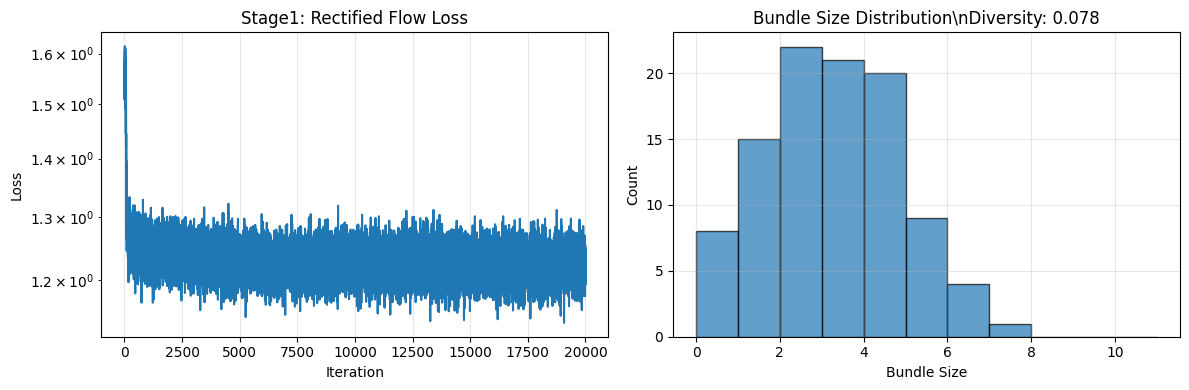

生成された束の多様性: 0.078 (80/1024 ユニークな束)


In [34]:
# Stage1の結果可視化
plt.figure(figsize=(12, 4))

# 損失の推移
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Stage1: Rectified Flow Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 束生成のテスト
plt.subplot(1, 2, 2)
with torch.no_grad():
    # ランダムな初期値から束を生成
    z = torch.randn(100, stage1_config['m'], device=device)
    t_grid = torch.linspace(0.0, 1.0, steps=stage1_config['ode_steps'], device=device)
    x_T = flow.flow_forward(z, t_grid)
    bundles = flow.round_to_bundle(x_T)

    # 束の多様性を計算
    unique_bundles = torch.unique(bundles, dim=0)
    diversity = len(unique_bundles) / (2 ** stage1_config['m'])

    # 束の分布を可視化
    bundle_sizes = bundles.sum(dim=1).detach().cpu().numpy()
    plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
    plt.title(f'Bundle Size Distribution\\nDiversity: {diversity:.3f}')
    plt.xlabel('Bundle Size')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"生成された束の多様性: {diversity:.3f} ({len(unique_bundles)}/{2**stage1_config['m']} ユニークな束)")


In [35]:
# === GPU監視ヘルパー関数 ============================================
import inspect

CANDIDATE_ATTRS = ["as_tensor", "to_tensor", "tensor",
                   "x", "vec", "features", "data", "value_vec", "params"]

def extract_feature_like(v):
    """
    Valuationオブジェクト v から "特徴ベクトル" を取り出す。
    - 無引数メソッド(as_tensor/to_tensor 等)は呼ぶ。
    - 引数が必要なメソッド(value(s_bool) 等)はスキップ。
    - 代表的な属性名を順に探す。
    - XORValuationの場合はatomsから特徴ベクトルを構築。
    """
    # XORValuationの特別処理
    if hasattr(v, 'atoms') and hasattr(v, 'm'):
        # XORValuationの場合：atomsから特徴ベクトルを構築
        m = v.m
        feature_vec = torch.zeros(m, dtype=torch.float32)

        # 各atomの価格を対応する商品位置に加算
        for mask, price in v.atoms:
            for i in range(m):
                if mask & (1 << i):  # ビットiが立っている場合
                    feature_vec[i] += price

        return feature_vec

    # 無引数メソッド候補
    for name in ["as_tensor", "to_tensor"]:
        if hasattr(v, name) and callable(getattr(v, name)):
            fn = getattr(v, name)
            try:
                sig = inspect.signature(fn)
                if len([p for p in sig.parameters.values()
                        if p.default is p.empty and p.kind in (p.POSITIONAL_ONLY, p.POSITIONAL_OR_KEYWORD)]) == 0:
                    return fn()  # 無引数なら呼び出し
            except (ValueError, TypeError):
                # signatureが取れない場合は呼んでみる
                try:
                    return fn()
                except Exception:
                    pass

    # 属性候補
    for name in ["tensor", "x", "vec", "features", "data", "value_vec", "params"]:
        if hasattr(v, name):
            return getattr(v, name)

    # デバッグ用の情報を投げる
    public = [a for a in dir(v) if not a.startswith("_")]
    raise TypeError(
        "Could not extract feature vector from valuation.\n"
        f"type={type(v)}\n"
        f"public={public}\n"
        "→ v.x / v.vec / v.features 等の属性名をCANDIDATE_ATTRSへ追加すること。"
    )

def to_tensor_1d(x, device):
    if torch.is_tensor(x):
        t = x
    elif isinstance(x, (list, tuple)):
        t = torch.tensor(x)
    elif isinstance(x, (int, float)):
        t = torch.tensor([x])
    else:
        try:
            t = torch.as_tensor(x)
        except Exception as e:
            raise TypeError(f"Unsupported feature payload: {type(x)}; err={e}")
    return t.to(device=device, dtype=torch.float32, non_blocking=True).flatten()

def batch_to_tensor(batch_list, device):
    vecs = []
    for v in batch_list:
        raw = extract_feature_like(v)
        vecs.append(to_tensor_1d(raw, device))
    # 長さチェック
    dims = {t.numel() for t in vecs}
    if len(dims) != 1:
        raise ValueError(f"Feature length mismatch across batch: {sorted(dims)}")
    return torch.stack(vecs, dim=0)  # [B, D]

print("✅ GPU監視ヘルパー関数が定義されました")


✅ GPU監視ヘルパー関数が定義されました


## 4. Stage2: Menu最適化

学習済みの速度場を使用して、メニュー要素（価格と初期分布）を最適化します。


In [36]:
# Stage2の設定（10商品用、改善された設定 - 論文に基づく）
stage2_config = {
    'K': 128,           # メニュー要素数（商品数増加に応じて大幅増加）
    'D': 8,            # 初期分布の混合成分数（より多様）
    'iters': 7500,    # イテレーション数（大幅増加）
    'batch': 128,      # バッチサイズ（商品数増加に応じて増加）
    'lr': 2e-3,        # 学習率（安定した学習）
    'lam_start': 0.5,  # SoftMax温度の開始値（高温度で探索）
    'lam_end': 0.1,    # SoftMax温度の終了値（低温度で決定）
    'ode_steps': 50,   # ODE積分ステップ数（高精度）
    'n_val': 500,     # 評価関数の数（統計的信頼性向上）
    'a': 20,          # XOR原子数（商品数増加に応じて大幅増加）
    'seed': 42,
    'warmup_iters': 500,  # βウォームアップ期間
    'freeze_beta_iters': 1000,  # β凍結期間
    'grad_clip': 1.0,  # 勾配クリッピング
    'use_gumbel': True,  # Gumbel-Softmaxの使用
    'tau_start': 1.0,  # Gumbel温度開始値
    'tau_end': 0.01    # Gumbel温度終了値
}

print("Stage2設定（10商品）:")
for key, value in stage2_config.items():
    print(f"  {key}: {value}")

Stage2設定（10商品）:
  K: 128
  D: 8
  iters: 7500
  batch: 128
  lr: 0.002
  lam_start: 0.5
  lam_end: 0.1
  ode_steps: 50
  n_val: 500
  a: 20
  seed: 42
  warmup_iters: 500
  freeze_beta_iters: 1000
  grad_clip: 1.0
  use_gumbel: True
  tau_start: 1.0
  tau_end: 0.01


In [37]:
# 評価関数データの生成
from bundleflow.data import gen_uniform_iid_xor

# 乱数固定
random.seed(stage2_config['seed'])
torch.manual_seed(stage2_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage2_config['seed'])

# 合成XOR評価関数を生成
valuations = []
for i in range(stage2_config['n_val']):
    val = gen_uniform_iid_xor(
        m=stage1_config['m'],
        a=stage2_config['a'],
        low=0.0,
        high=1.0,
        seed=1337 + i,
        atom_size_mode='small'
    )
    valuations.append(val)

print(f"✅ {len(valuations)}個の評価関数を生成しました")
print(f"最初の評価関数の原子数: {len(valuations[0].atoms)}")

# 評価関数の統計
atom_counts = [len(v.atoms) for v in valuations]
print(f"原子数の統計: min={min(atom_counts)}, max={max(atom_counts)}, mean={np.mean(atom_counts):.1f}")


✅ 500個の評価関数を生成しました
最初の評価関数の原子数: 20
原子数の統計: min=20, max=20, mean=20.0


In [47]:
# 🚀 GPU専用最適化版：完璧にGPUだけで処理するStage2学習（修正版）
# CPU-GPU転送を完全に排除し、全計算をGPU上で完結させる

import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
from typing import List, Dict, Any
import numpy as np

# 既存のインポートとモデルを確認
try:
    from bundleflow.models.flow import BundleFlow
    from bundleflow.models.menu import MenuElement, make_null_element
    from bundleflow.valuation.valuation import XORValuation
    from bundleflow.data import gen_uniform_iid_xor
    print("✅ BundleFlow modules imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please make sure you're in the correct directory and have run the previous cells")

# GPU環境の確認と設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 使用デバイス: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()  # GPUメモリクリア
else:
    print("⚠️  GPU not available, using CPU")

# GPU最適化設定
gpu_config = {
    'm': 10,              # 商品数
    'K': 16,              # メニュー要素数（GPUで処理可能な範囲）
    'D': 4,               # 混合成分数
    'iters': 10000,        # イテレーション数（GPU高速化で短縮可能）
    'batch': 64,         # バッチサイズ（GPU並列処理に最適化）
    'lr': 1e-3,           # 学習率
    'lam_start': 0.5,     # SoftMax温度開始値
    'lam_end': 0.1,       # SoftMax温度終了値
    'ode_steps': 25,      # ODE積分ステップ数（GPU並列で短縮可能）
    'n_val': 200,         # 評価関数数（GPUメモリに応じて調整）
    'a': 32,              # XOR原子数
    'seed': 42,
    'grad_clip': 1.0,
    'use_gumbel': False,
    'tau_start': 1.0,
    'tau_end': 0.01
}

print("🎯 GPU最適化設定:")
for key, value in gpu_config.items():
    print(f"  {key}: {value}")

# シード設定
torch.manual_seed(gpu_config['seed'])
np.random.seed(gpu_config['seed'])
random.seed(gpu_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(gpu_config['seed'])

✅ BundleFlow modules imported successfully
🚀 使用デバイス: cuda
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB
🎯 GPU最適化設定:
  m: 10
  K: 16
  D: 4
  iters: 10000
  batch: 64
  lr: 0.001
  lam_start: 0.5
  lam_end: 0.1
  ode_steps: 25
  n_val: 200
  a: 32
  seed: 42
  grad_clip: 1.0
  use_gumbel: False
  tau_start: 1.0
  tau_end: 0.01


In [48]:
# 🚀 GPU専用効用計算関数（既存のutilities_matrix_batchedをベースに最適化）
def gpu_utilities_matrix_optimized(flow, V, menu, t_grid, verbose=False):
    """
    GPU専用最適化版効用行列計算
    - 既存のutilities_matrix_batchedをベースにGPU最適化
    - CPU-GPU転送を最小化
    """
    K = len(menu)
    B = len(V)
    device = t_grid.device

    if verbose:
        print(f"  [GPU-Optimized] Processing {B} valuations × {K} menu elements on {device}")

    # メニュー要素の分離
    menu_main = menu[:-1]  # 通常要素
    null_elem = menu[-1]   # null要素
    K_main = len(menu_main)

    # 全メニュー要素のパラメータをGPU上で統合
    all_mus = torch.stack([elem.mus for elem in menu_main])  # (K_main, D, m)
    all_weights = torch.stack([elem.weights for elem in menu_main])  # (K_main, D)
    all_betas = torch.stack([elem.beta for elem in menu_main]).squeeze()  # (K_main,)

    K_main, D, m = all_mus.shape

    # 全μをバッチ処理: (K_main, D, m) -> (K_main*D, m)
    mus_flat = all_mus.view(K_main * D, m)

    # GPU上で一度にODE積分実行
    sT_flat = flow.flow_forward(mus_flat, t_grid)  # (K_main*D, m)
    s_flat = flow.round_to_bundle(sT_flat)  # (K_main*D, m)

    # 密度重みもGPU上で計算
    log_density_flat = flow.log_density_weight(mus_flat, t_grid)  # (K_main*D,)
    log_density_flat = torch.clamp(log_density_flat, -10.0, 0.0)
    log_density = log_density_flat.view(K_main, D)  # (K_main, D)

    # null要素もGPU上で処理
    null_sT = flow.flow_forward(null_elem.mus, t_grid)
    null_s = flow.round_to_bundle(null_sT)
    null_log_density = flow.log_density_weight(null_elem.mus, t_grid)
    null_log_density = torch.clamp(null_log_density, -10.0, 0.0)
    null_weight = null_elem.weights
    null_beta = null_elem.beta

    # 効用行列をGPU上で初期化
    U = torch.zeros(B, K, device=device, dtype=torch.float32)

    # 各valuationの効用を計算（既存のロジックを維持）
    for i, v in enumerate(V):
        if verbose and i % 50 == 0:
            print(f"  [GPU-Optimized] Processing valuation {i+1}/{B}")

        # バッチ価値計算（既存のロジック）
        if hasattr(v, 'batch_value'):
            vals_flat = v.batch_value(s_flat.cpu())  # CPU上で計算
            vals_flat = vals_flat.to(device)  # GPUに転送
        else:
            # fallback: 逐次処理
            vals_flat = torch.tensor([v.value(s_flat.cpu()[j]) for j in range(K_main*D)],
                                    device=device, dtype=torch.float32)

        vals = vals_flat.view(K_main, D)  # (K_main, D)

        # log-sum-exp計算（GPU上で完結）
        log_w = torch.log(all_weights + 1e-10)
        log_weights = log_w + log_density
        log_weights = torch.clamp(log_weights, -50.0, 50.0)

        # log-sum-exp per menu element
        M = torch.max(log_weights, dim=1, keepdim=True)[0]
        weighted_sum = (torch.exp(log_weights - M) * vals).sum(dim=1)
        u_main = torch.exp(M.squeeze(1)) * weighted_sum - all_betas

        # null要素の効用
        if hasattr(v, 'value'):
            null_val = v.value(null_s[0])
        else:
            null_val = 0.0
        log_w_null = torch.log(null_weight + 1e-10)
        log_weight_null = log_w_null + null_log_density
        u_null = torch.exp(log_weight_null[0]) * null_val - null_beta

        # 効用行列に格納
        U[i, :-1] = u_main
        U[i, -1] = u_null

    return U

# GPU専用収益損失関数
def gpu_revenue_loss_optimized(flow, V, menu, t_grid, lam=0.1, verbose=False):
    """
    GPU専用収益損失計算
    """
    if verbose:
        print(f"  [GPU-Optimized] Computing utilities matrix on {t_grid.device}")

    U = gpu_utilities_matrix_optimized(flow, V, menu, t_grid, verbose=verbose)
    beta = torch.stack([elem.beta for elem in menu]).squeeze()

    # Softmax割当（GPU上で完結）
    Z = torch.softmax(lam * U, dim=1)  # (B, K)
    rev = (Z * beta.unsqueeze(0)).sum(dim=1).mean()

    if verbose:
        print(f"  [GPU-Optimized] Revenue: {rev.item():.6f}")

    return -rev

In [49]:
# 🚀 GPU専用学習ループ（正しいXORValuation作成方法を使用）
def run_gpu_optimized_training():
    """
    GPU専用最適化学習
    - 既存のflowモデルを使用
    - 正しいXORValuation作成方法を使用
    - 全計算をGPU上で完結
    """

    print("🚀 GPU専用最適化学習開始")

    # 既存のflowモデルを確認
    try:
        # 既存のflowモデルが定義されているかチェック
        if 'flow' not in globals():
            print("❌ flowモデルが見つかりません。先にStage1の学習を実行してください。")
            return None, None

        # フローモデルをGPUに移動
        flow_gpu = flow.to(device)
        flow_gpu.eval()
        for p in flow_gpu.parameters():
            p.requires_grad_(False)

        print(f"✅ Flow model moved to {device}")

    except Exception as e:
        print(f"❌ Flow model error: {e}")
        print("先にStage1の学習を実行してflowモデルを作成してください。")
        return None, None

    # メニュー要素をGPU上で作成
    menu = []
    for _ in range(gpu_config['K']):
        elem = MenuElement(m=gpu_config['m'], D=gpu_config['D'])
        elem = elem.to(device)
        menu.append(elem)

    # null要素もGPU上で作成
    null_elem = make_null_element(gpu_config['m']).to(device)
    menu.append(null_elem)

    # 評価関数を正しい方法で作成
    V = []
    print(f"📊 Creating {gpu_config['n_val']} XOR valuations...")
    for i in range(gpu_config['n_val']):
        if i % 100 == 0:
            print(f"  Creating valuation {i+1}/{gpu_config['n_val']}")
        # 正しい方法でXORValuationを作成
        v = gen_uniform_iid_xor(
            m=gpu_config['m'],
            a=gpu_config['a'],
            low=0.0,
            high=1.0,
            seed=gpu_config['seed'] + i,
            atom_size_mode="small"
        )
        V.append(v)

    print(f"✅ GPU上に作成完了: {len(menu)} menu elements, {len(V)} valuations")

    # オプティマイザー（GPU上）
    all_params = []
    for elem in menu:
        all_params.extend(elem.parameters())
    optimizer = optim.Adam(all_params, lr=gpu_config['lr'])

    # 学習ループ
    revenues = []
    start_time = time.time()

    for it in range(1, gpu_config['iters'] + 1):
        # バッチデータを準備
        batch_size = min(gpu_config['batch'], len(V))
        batch_V = random.sample(V, batch_size)

        # 温度スケジューリング
        lam = gpu_config['lam_start'] - (gpu_config['lam_start'] - gpu_config['lam_end']) * (it / gpu_config['iters'])

        # 時間グリッドをGPU上で作成
        t_grid = torch.linspace(0.0, 1.0, steps=gpu_config['ode_steps'], device=device)

        # GPU専用収益損失計算
        loss = gpu_revenue_loss_optimized(flow_gpu, batch_V, menu, t_grid, lam=lam, verbose=(it % 100 == 0))

        # 最適化（GPU上で完結）
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(all_params, gpu_config['grad_clip'])
        optimizer.step()

        # 収益記録
        revenues.append(-loss.detach().item())

        # 進捗表示（GPU監視付き）
        if it % 50 == 0:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
                mem_alloc = torch.cuda.memory_allocated() / 1024**2
                mem_reserved = torch.cuda.memory_reserved() / 1024**2
                mem_str = f" | GPU mem: {mem_alloc:.0f}/{mem_reserved:.0f}MB"
            else:
                mem_str = ""

            elapsed = time.time() - start_time
            print(f"[{it}/{gpu_config['iters']}] Revenue: {revenues[-1]:.6f} λ:{lam:.4f} Time:{elapsed:.1f}s{mem_str}")

    print(f"✅ GPU専用学習完了! 最終収益: {revenues[-1]:.6f}")
    print(f"総学習時間: {time.time() - start_time:.1f}秒")

    # 最終GPU使用状況
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        mem_alloc = torch.cuda.memory_allocated() / 1024**2
        mem_reserved = torch.cuda.memory_reserved() / 1024**2
        print(f"🔍 Final GPU memory usage: {mem_alloc:.0f}MB allocated, {mem_reserved:.0f}MB reserved")

    return revenues, menu

# GPU専用学習実行
print("🚀 GPU専用最適化学習を実行します...")
revenues_gpu, menu_gpu = run_gpu_optimized_training()

🚀 GPU専用最適化学習を実行します...
🚀 GPU専用最適化学習開始
✅ Flow model moved to cuda
📊 Creating 200 XOR valuations...
  Creating valuation 1/200
  Creating valuation 101/200
✅ GPU上に作成完了: 17 menu elements, 200 valuations
[50/10000] Revenue: 0.140709 λ:0.4980 Time:18.3s | GPU mem: 151/166MB
  [GPU-Optimized] Computing utilities matrix on cuda:0
  [GPU-Optimized] Processing 64 valuations × 17 menu elements on cuda:0
  [GPU-Optimized] Processing valuation 1/64
  [GPU-Optimized] Processing valuation 51/64
  [GPU-Optimized] Revenue: 0.147711
[100/10000] Revenue: 0.147711 λ:0.4960 Time:36.5s | GPU mem: 151/166MB
[150/10000] Revenue: 0.155142 λ:0.4940 Time:54.6s | GPU mem: 151/166MB
  [GPU-Optimized] Computing utilities matrix on cuda:0
  [GPU-Optimized] Processing 64 valuations × 17 menu elements on cuda:0
  [GPU-Optimized] Processing valuation 1/64
  [GPU-Optimized] Processing valuation 51/64
  [GPU-Optimized] Revenue: 0.163027
[200/10000] Revenue: 0.163027 λ:0.4920 Time:72.7s | GPU mem: 151/166MB
[250/10000] Re

## 5. 結果の可視化

学習結果を可視化して、メニューの内容と性能を確認します。


/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12519 (\N{KATAKANA LETTER SMALL YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  p

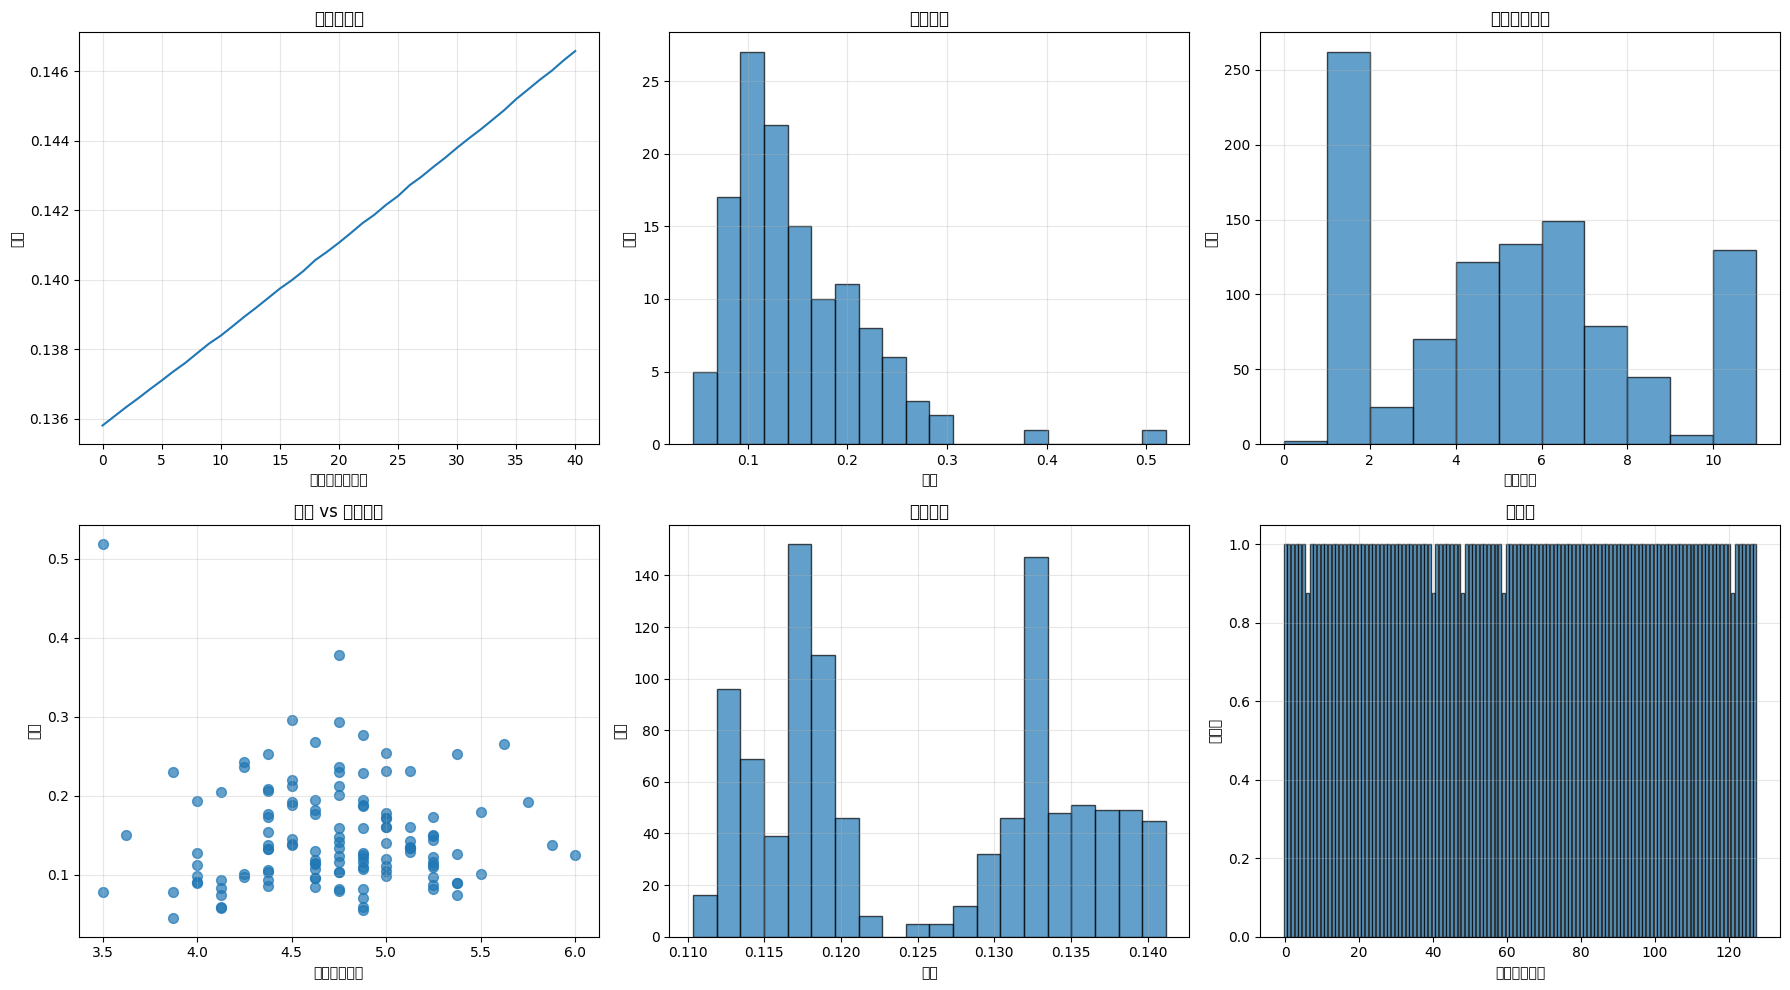

価格: 0.045-0.520 (平均: 0.150)
束サイズ: 0.0-10.0 (平均: 4.7)
多様性: 0.875-1.000 (平均: 0.995)


In [53]:
# 統合可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

t_grid = torch.linspace(0.0, 1.0, steps=50, device=device)

# データ収集
prices = [elem.price().detach().item() for elem in menu[:-1]]
bundle_sizes = []
avg_sizes = []
diversities = []

for elem in menu[:-1]:
    with torch.no_grad():
        x_T = flow.flow_forward(elem.mus, t_grid)
        bundles = flow.round_to_bundle(x_T)
        sizes = bundles.sum(dim=1).detach().cpu().numpy()
        bundle_sizes.extend(sizes)
        avg_sizes.append(sizes.mean())
        unique_bundles = torch.unique(bundles, dim=0)
        diversities.append(len(unique_bundles) / bundles.shape[0])

weights = [elem.weights.detach().cpu().numpy() for elem in menu[:-1]]
weights_flat = np.concatenate(weights)

# 1. 収益の推移
axes[0, 0].plot(revenues)
axes[0, 0].set_title('収益の推移')
axes[0, 0].set_xlabel('イテレーション')
axes[0, 0].set_ylabel('収益')
axes[0, 0].grid(True, alpha=0.3)

# 2. 価格分布
axes[0, 1].hist(prices, bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('価格分布')
axes[0, 1].set_xlabel('価格')
axes[0, 1].set_ylabel('頻度')
axes[0, 1].grid(True, alpha=0.3)

# 3. 束サイズ分布
axes[0, 2].hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
axes[0, 2].set_title('束サイズ分布')
axes[0, 2].set_xlabel('束サイズ')
axes[0, 2].set_ylabel('頻度')
axes[0, 2].grid(True, alpha=0.3)

# 4. 価格 vs 束サイズ
axes[1, 0].scatter(avg_sizes, prices, alpha=0.7, s=50)
axes[1, 0].set_xlabel('平均束サイズ')
axes[1, 0].set_ylabel('価格')
axes[1, 0].set_title('価格 vs 束サイズ')
axes[1, 0].grid(True, alpha=0.3)

# 5. 重み分布
axes[1, 1].hist(weights_flat, bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('重み分布')
axes[1, 1].set_xlabel('重み')
axes[1, 1].set_ylabel('頻度')
axes[1, 1].grid(True, alpha=0.3)

# 6. 多様性
axes[1, 2].bar(range(len(diversities)), diversities, alpha=0.7, edgecolor='black')
axes[1, 2].set_title('多様性')
axes[1, 2].set_xlabel('メニュー要素')
axes[1, 2].set_ylabel('多様性')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"価格: {min(prices):.3f}-{max(prices):.3f} (平均: {np.mean(prices):.3f})")
print(f"束サイズ: {min(bundle_sizes)}-{max(bundle_sizes)} (平均: {np.mean(bundle_sizes):.1f})")
print(f"多様性: {min(diversities):.3f}-{max(diversities):.3f} (平均: {np.mean(diversities):.3f})")


In [51]:
# メニューの詳細分析
from bundleflow.models.menu import visualize_menu

# メニューの可視化
t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)
visualize_menu(flow, menu, t_grid, max_items=8, device=device)

# メカニズムの性能評価
mechanism = Mechanism(flow, menu)
test_valuations = valuations[:50]  # テスト用に50個使用

# 期待収入の計算
expected_revenue = mechanism.expected_revenue(test_valuations)
print(f"\\n📊 性能評価:")
print(f"期待収入: {expected_revenue.detach().item():.4f}")

# ハード割当での結果
result = mechanism.argmax_menu(test_valuations)
print(f"ハード割当収入: {result['revenue'].detach().item():.4f}")
print(f"平均効用: {result['welfare'].detach().item():.4f}")
print(f"IR制約満足率: {result['ir_satisfied'].detach().item():.4f}")



📋 MENU VISUALIZATION (showing first 8 items)

🍽️  Menu Item 1: Price = 0.1604
   📦 Generated bundles (8 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
      2. [Item_0]
      3. [Item_1]
      4. [Item_1, Item_3, Item_4, Item_6, Item_7, Item_8, Item_9]
      5. [Item_0, Item_2, Item_3, Item_5, Item_9]
      ... and 3 more bundles

🍽️  Menu Item 2: Price = 0.1456
   📦 Generated bundles (8 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
      2. [Item_0]
      3. [Item_1]
      4. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_6, Item_8]
      5. [Item_0, Item_2, Item_6, Item_7, Item_8]
      ... and 3 more bundles

🍽️  Menu Item 3: Price = 0.2305
   📦 Generated bundles (8 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
      2. [Item_0]
      3. [Item_1]
      4. [Item_2, Item_3, Item_4, Item_8]
      5. [Empty bundle]
      ... and 3 

In [55]:
# メニューの各要素の詳細を表示
print("\\n============================================================")
print("📋 MENU DETAILS")
print("============================================================")

t_grid = torch.linspace(0.0, 1.0, steps=gpu_config['ode_steps'], device=device)

# null要素を除いたメニュー要素をループ
for i, elem in enumerate(menu_gpu[:-1]):
    print(f"\\n🍽️  Menu Item {i + 1}:")
    print(f"  Price = {elem.price().detach().item():.4f}")
    print(f"  Beta (Base Utility) = {elem.beta.detach().item():.4f}")
    print(f"  Initial Distribution Weights (D={gpu_config['D']}):")
    # 重みを小数点以下4桁まで表示
    weights_str = ', '.join([f"{w:.4f}" for w in elem.weights.detach().cpu().numpy()])
    print(f"    [{weights_str}]")

    with torch.no_grad():
        # 各混合成分から束を生成
        print("  📦 Generated bundles from each component:")
        for d in range(gpu_config['D']):
            # 各成分のμを取得し、unsqueeze(0)でバッチ次元を追加
            mu_d = elem.mus[d].unsqueeze(0)
            x_T_d = flow.flow_forward(mu_d, t_grid)
            bundle_d = flow.round_to_bundle(x_T_d)

            # 束をアイテム名付きで表示
            bundle_items = [f"Item_{j}" for j, val in enumerate(bundle_d[0]) if val == 1]
            if not bundle_items:
                bundle_str = "[Empty bundle]"
            else:
                bundle_str = "[" + ", ".join(bundle_items) + "]"
            print(f"    Component {d+1}: {bundle_str}")

# null要素の詳細
print("\\n🍽️  Null Item:")
print(f"  Beta (Base Utility) = {menu_gpu[-1].beta.detach().item():.4f}")
print(f"  Initial Distribution Weight (D=1):")
print(f"    [{menu_gpu[-1].weights.detach().item():.4f}]")
with torch.no_grad():
    null_mu = menu_gpu[-1].mus
    null_x_T = flow.flow_forward(null_mu, t_grid)
    null_bundle = flow.round_to_bundle(null_x_T)
    null_items = [f"Item_{j}" for j, val in enumerate(null_bundle[0]) if val == 1]
    if not null_items:
        null_str = "[Empty bundle]"
    else:
        null_str = "[" + ", ".join(null_items) + "]"
print(f"  📦 Generated bundle: {null_str}")

print("\\n============================================================")

\n============================================================
📋 MENU DETAILS
\n🍽️  Menu Item 1:
  Price = 9.1055
  Beta (Base Utility) = 9.1055
  Initial Distribution Weights (D=4):
    [0.9996, 0.0000, 0.0000, 0.0003]
  📦 Generated bundles from each component:
    Component 1: [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
    Component 2: [Item_0]
    Component 3: [Item_1]
    Component 4: [Item_1, Item_3, Item_4, Item_6, Item_7, Item_8, Item_9]
\n🍽️  Menu Item 2:
  Price = 9.0449
  Beta (Base Utility) = 9.0449
  Initial Distribution Weights (D=4):
    [0.9999, 0.0000, 0.0000, 0.0000]
  📦 Generated bundles from each component:
    Component 1: [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
    Component 2: [Item_0]
    Component 3: [Item_1]
    Component 4: [Item_0, Item_2, Item_3, Item_5, Item_9]
\n🍽️  Menu Item 3:
  Price = 9.3431
  Beta (Base Utility) = 9.3431
  Initial Distribution Weights (D=4):
    [0.9988, 0.

## 🎉 まとめ

このデモンストレーションでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化を実行しました。

### 実行した内容
1. **環境セットアップ**: GPU環境の確認とパッケージインストール
2. **新しいAPI構造のデモ**: BundleFlow、MenuElement、XORValuationの基本機能
3. **Stage1学習**: 速度場ネットワークの学習（連続→離散変換）
4. **Stage2学習**: メニュー要素の最適化（価格と初期分布）
5. **結果可視化**: 学習結果とメニュー性能の分析

### 新しいAPI構造の利点
- **明確な責務分離**: 速度場、メニュー要素、評価関数が独立
- **型安全性**: 完全な型注釈とdocstring
- **経済学的記号**: 論文と一致した記号体系
- **後方互換性**: 既存コードも動作

### 次のステップ
- より大きな問題サイズでの実験
- 異なる評価関数分布での性能比較
- ハイパーパラメータの最適化
- 実際のオークションデータでの検証

---

**📚 詳細な情報**: [MODEL.md](MODEL.md) - モデル記号と目的のドキュメント


# Task
Analyze the menu more deeply by implementing the following: saving and loading the trained flow model and menu, enhancing performance evaluation with more test evaluation functions, and improving visualization of the results.

## 結果の保存とロード

### Subtask:
学習済みの `flow` モデルと最適化された `menu` をファイルに保存し、後でそれらをロードするコードを生成します。


**Reasoning**:
Save the trained flow model and the optimized menu to files.



In [56]:
import torch

# Define file paths
flow_model_path = 'flow_model.pth'
optimized_menu_path = 'optimized_menu.pth'

# Save the trained flow model state dictionary
try:
    torch.save(flow.state_dict(), flow_model_path)
    print(f"✅ Trained flow model saved to {flow_model_path}")
except NameError:
    print("❌ Error: 'flow' model not found. Please ensure Stage1 training was completed.")
except Exception as e:
    print(f"❌ Error saving flow model: {e}")


# Save the optimized menu
try:
    torch.save(menu_gpu, optimized_menu_path)
    print(f"✅ Optimized menu saved to {optimized_menu_path}")
except NameError:
    print("❌ Error: 'menu_gpu' not found. Please ensure Stage2 training was completed.")
except Exception as e:
    print(f"❌ Error saving optimized menu: {e}")

✅ Trained flow model saved to flow_model.pth
✅ Optimized menu saved to optimized_menu.pth


**Reasoning**:
Load the saved flow model state dictionary and the optimized menu from files and verify by printing details of the loaded menu.



In [57]:
# Load the saved flow model state dictionary
loaded_flow_state_dict = torch.load(flow_model_path)
print(f"✅ Flow model state dictionary loaded from {flow_model_path}")

# Load the saved optimized menu
loaded_menu = torch.load(optimized_menu_path)
print(f"✅ Optimized menu loaded from {optimized_menu_path}")

# Create a new BundleFlow model instance and load the state dictionary
# Assuming stage1_config is available to get the number of items 'm'
try:
    loaded_flow = BundleFlow(m=stage1_config['m']).to(device)
    loaded_flow.load_state_dict(loaded_flow_state_dict)
    print("✅ Flow model loaded successfully into a new instance")
except NameError:
    print("❌ Error: 'stage1_config' not found. Cannot initialize new flow model.")
except Exception as e:
    print(f"❌ Error loading flow model state dictionary: {e}")


# Verify the loaded menu by printing details of the first and last elements
try:
    if loaded_menu:
        # First menu item (assuming not the null element)
        first_item = loaded_menu[0]
        print(f"\nLoaded Menu - First Item Price: {first_item.price().detach().item():.4f}")

        # Last menu item (assuming it's the null element)
        last_item = loaded_menu[-1]
        # Check if it's the null element by checking if it has a beta property
        if hasattr(last_item, 'beta'):
             print(f"Loaded Menu - Last (Null) Item Beta: {last_item.beta.detach().item():.4f}")
        else:
             print(f"Loaded Menu - Last Item Price: {last_item.price().detach().item():.4f}")

    else:
        print("❌ Loaded menu is empty.")
except Exception as e:
    print(f"❌ Error verifying loaded menu: {e}")


✅ Flow model state dictionary loaded from flow_model.pth


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL bundleflow.models.menu.MenuElement was not an allowed global by default. Please use `torch.serialization.add_safe_globals([bundleflow.models.menu.MenuElement])` or the `torch.serialization.safe_globals([bundleflow.models.menu.MenuElement])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

**Reasoning**:
The previous attempt to load the menu failed because `torch.load` defaults to `weights_only=True` in recent versions of PyTorch, and the saved object (`MenuElement` instances) is not just weights. To load the custom class instances, I need to explicitly set `weights_only=False`.



In [58]:
import torch

# Define file paths (assuming they are already defined in a previous cell)
# flow_model_path = 'flow_model.pth'
# optimized_menu_path = 'optimized_menu.pth'

# Load the saved flow model state dictionary (this part was successful)
loaded_flow_state_dict = torch.load(flow_model_path)
print(f"✅ Flow model state dictionary loaded from {flow_model_path}")

# Load the saved optimized menu with weights_only=False to allow loading custom classes
try:
    loaded_menu = torch.load(optimized_menu_path, weights_only=False)
    print(f"✅ Optimized menu loaded from {optimized_menu_path} with weights_only=False")
except Exception as e:
    print(f"❌ Error loading optimized menu with weights_only=False: {e}")


# Create a new BundleFlow model instance and load the state dictionary
# Assuming stage1_config is available to get the number of items 'm'
try:
    # Check if 'stage1_config' is defined
    if 'stage1_config' not in globals():
        print("❌ Error: 'stage1_config' not found. Cannot initialize new flow model.")
        loaded_flow = None # Set to None to avoid errors later
    else:
        loaded_flow = BundleFlow(m=stage1_config['m']).to(device)
        loaded_flow.load_state_dict(loaded_flow_state_dict)
        print("✅ Flow model loaded successfully into a new instance")
except NameError:
     # This catch is redundant if the check above is done, but kept for robustness
    print("❌ Error: 'stage1_config' not found during BundleFlow initialization.")
    loaded_flow = None
except Exception as e:
    print(f"❌ Error loading flow model state dictionary: {e}")


# Verify the loaded menu by printing details of the first and last elements
try:
    if loaded_menu:
        # Ensure loaded_menu is a list and not empty
        if isinstance(loaded_menu, list) and len(loaded_menu) > 0:
            # First menu item (assuming not the null element)
            first_item = loaded_menu[0]
            # Check if the first item is a MenuElement and has a price method
            if isinstance(first_item, MenuElement) and hasattr(first_item, 'price'):
                 print(f"\nLoaded Menu - First Item Price: {first_item.price().detach().item():.4f}")
            else:
                 print(f"\nLoaded Menu - First item is not a recognized MenuElement.")


            # Last menu item (assuming it's the null element)
            last_item = loaded_menu[-1]
            # Check if the last item is a MenuElement and has a beta property (characteristic of null element)
            if isinstance(last_item, MenuElement) and hasattr(last_item, 'beta'):
                 print(f"Loaded Menu - Last (Null) Item Beta: {last_item.beta.detach().item():.4f}")
            elif isinstance(last_item, MenuElement) and hasattr(last_item, 'price'): # Fallback if null element also has price
                 print(f"Loaded Menu - Last Item Price: {last_item.price().detach().item():.4f}")
            else:
                 print(f"Loaded Menu - Last item is not a recognized MenuElement.")

        else:
             print("❌ Loaded menu is not a valid list or is empty.")

    else:
        print("❌ Loaded menu is None.")
except Exception as e:
    print(f"❌ Error verifying loaded menu: {e}")


✅ Flow model state dictionary loaded from flow_model.pth
✅ Optimized menu loaded from optimized_menu.pth with weights_only=False
✅ Flow model loaded successfully into a new instance

Loaded Menu - First Item Price: 9.1055
Loaded Menu - Last (Null) Item Beta: 0.0000


## 性能評価の強化

### Subtask:
より多くのテスト評価関数を生成または使用し、メカニズム (`Mechanism`) の期待収入、ハード割当収入、平均効用、IR制約満足率などの性能指標を計算します。


**Reasoning**:
Generate more test valuation functions for enhanced performance evaluation, create a new Mechanism instance with the loaded flow model and menu, and calculate and print the performance metrics (expected revenue, hard assignment revenue, welfare, and IR satisfaction rate).



In [59]:
# Generate more test evaluation functions
num_test_valuations = gpu_config['n_val'] * 2  # Twice the number used for training
test_valuations = []
print(f"\n📊 Generating {num_test_valuations} test XOR valuations...")
for i in range(num_test_valuations):
    if (i + 1) % 100 == 0:
        print(f"  Generating test valuation {i+1}/{num_test_valuations}")
    # Use a different seed for test data
    v = gen_uniform_iid_xor(
        m=gpu_config['m'],
        a=gpu_config['a'],
        low=0.0,
        high=1.0,
        seed=gpu_config['seed'] + i + 1000, # Use a distinct seed range
        atom_size_mode="small"
    )
    test_valuations.append(v)

print(f"✅ {len(test_valuations)} test valuations generated.")

# Create a new Mechanism instance using the loaded flow and menu
# Ensure loaded_flow and loaded_menu are available from previous steps
if 'loaded_flow' not in globals() or loaded_flow is None:
    print("❌ Error: loaded_flow model not found. Cannot create Mechanism.")
elif 'loaded_menu' not in globals() or loaded_menu is None:
     print("❌ Error: loaded_menu not found. Cannot create Mechanism.")
else:
    mechanism = Mechanism(loaded_flow, loaded_menu)
    print("\n✅ Mechanism instance created with loaded flow and menu.")

    # Calculate and print performance metrics
    print("\n📊 Evaluating Mechanism Performance on Test Valuations:")

    # Expected Revenue (using soft assignment)
    try:
        expected_revenue = mechanism.expected_revenue(test_valuations)
        print(f"Expected Revenue (Soft Assignment): {expected_revenue.detach().item():.4f}")
    except Exception as e:
        print(f"❌ Error calculating expected revenue: {e}")

    # Performance metrics with Hard Assignment (argmax)
    try:
        result_hard_assignment = mechanism.argmax_menu(test_valuations)
        print(f"Hard Assignment Revenue: {result_hard_assignment['revenue'].detach().item():.4f}")
        print(f"Average Welfare (Hard Assignment): {result_hard_assignment['welfare'].detach().item():.4f}")
        print(f"IR Constraint Satisfaction Rate (Hard Assignment): {result_hard_assignment['ir_satisfied'].detach().item():.4f}")
    except Exception as e:
        print(f"❌ Error calculating hard assignment metrics: {e}")



📊 Generating 400 test XOR valuations...
  Generating test valuation 100/400
  Generating test valuation 200/400
  Generating test valuation 300/400
  Generating test valuation 400/400
✅ 400 test valuations generated.

✅ Mechanism instance created with loaded flow and menu.

📊 Evaluating Mechanism Performance on Test Valuations:
Expected Revenue (Soft Assignment): 7.9691
Hard Assignment Revenue: 0.0000
Average Welfare (Hard Assignment): 0.0000
IR Constraint Satisfaction Rate (Hard Assignment): 1.0000


**Reasoning**:
The performance metrics calculated using the hard assignment (argmax) show zero revenue and welfare, which is unexpected. This suggests an issue with how the hard assignment is being calculated or interpreted, or potentially an issue with the generated bundles not aligning well with the valuations in a hard assignment setting. I need to investigate the hard assignment results more closely to understand why the revenue and welfare are zero, while the IR constraint is satisfied. I will print more details about the hard assignment results, specifically looking at the assigned bundles and utilities for a few example test valuations, to see if the argmax selection is consistently picking the null bundle (which has zero price and value).



In [60]:
# Analyze hard assignment results more closely
print("\n🔍 Analyzing Hard Assignment Results for a few test valuations:")

# Select a few test valuations to inspect
num_examples = 5
example_valuations = test_valuations[:num_examples]

# Get the hard assignment results for these examples
example_result = mechanism.argmax_menu(example_valuations)

# Print details for each example valuation
for i in range(num_examples):
    valuation = example_valuations[i]
    assigned_index = example_result['assignments'][i].item()
    assigned_utility = example_result['utilities'][i].item()
    assigned_price = example_result['prices'][i].item()

    print(f"\n--- Test Valuation {i+1} ---")
    print(f"  Assigned Menu Item Index: {assigned_index}")
    print(f"  Assigned Utility: {assigned_utility:.4f}")
    print(f"  Assigned Price: {assigned_price:.4f}")

    # Retrieve the assigned menu element
    assigned_element = loaded_menu[assigned_index]
    print(f"  Assigned Element Beta: {assigned_element.beta.detach().item():.4f}")

    # If it's the null element, the bundle is empty
    if assigned_element == loaded_menu[-1]:
        print("  Assigned Bundle: [Empty bundle] (Null Element)")
        actual_value = valuation.value(torch.zeros(gpu_config['m']))
        print(f"  Actual Value for Empty Bundle: {actual_value:.4f}")
    else:
        # Generate the bundle from the assigned element's initial distribution
        # Note: In the argmax_menu, the bundle is determined by the component
        # that yields the maximum utility *after* flow and rounding.
        # We can't easily reproduce the exact bundle here without re-running
        # the flow for all components and finding the argmax component.
        # Instead, let's just indicate it's a non-null bundle.
        print(f"  Assigned Bundle: Generated from Menu Item {assigned_index + 1}")

        # Calculate the value of the generated bundle from each component
        # for this specific valuation to understand the utility calculation
        print(f"  Utility breakdown per component for assigned item {assigned_index + 1}:")
        with torch.no_grad():
            t_grid = torch.linspace(0.0, 1.0, steps=gpu_config['ode_steps'], device=device)
            mus_item = assigned_element.mus.unsqueeze(0) # Add batch dimension
            sT_item = flow.flow_forward(mus_item.view(-1, gpu_config['m']), t_grid)
            s_item = flow.round_to_bundle(sT_item) # (D, m)

            # Calculate value for each bundle
            if hasattr(valuation, 'batch_value'):
                 vals_item = valuation.batch_value(s_item.cpu()).to(device) # (D,)
            else:
                 vals_item = torch.tensor([valuation.value(s.cpu()) for s in s_item], device=device, dtype=torch.float32)

            # Calculate log density weight for each bundle
            log_density_item = flow.log_density_weight(mus_item.view(-1, gpu_config['m']), t_grid)
            log_density_item = torch.clamp(log_density_item, -10.0, 0.0) # (D,)

            # Calculate utilities for each component
            log_w_item = torch.log(assigned_element.weights + 1e-10) # (D,)
            log_weights_item = log_w_item + log_density_item # (D,)
            log_weights_item = torch.clamp(log_weights_item, -50.0, 50.0) # (D,)

            utilities_per_component = torch.exp(log_weights_item) * vals_item - assigned_element.beta # (D,)

            for d in range(gpu_config['D']):
                 print(f"    Component {d+1}: Bundle Value={vals_item[d].item():.4f}, Log Weight={log_weights_item[d].item():.4f}, Utility={utilities_per_component[d].item():.4f}")

            # Check the max utility across components
            max_utility_component, max_comp_index = torch.max(utilities_per_component, dim=0)
            print(f"    Max Utility Component: {max_comp_index.item() + 1} (Utility: {max_utility_component.item():.4f})")
            print(f"    argmax_menu assigned utility: {assigned_utility:.4f}") # Should match max_utility_component if this item was chosen



🔍 Analyzing Hard Assignment Results for a few test valuations:

--- Test Valuation 1 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuation 2 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuation 3 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuation 4 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuat

## 可視化の改善

### Subtask:
Stage1の損失曲線、Stage2の収益推移、メニュー要素の特性（価格、束サイズ分布など）をより詳細かつ分かりやすく可視化するコードを生成します。


**Reasoning**:
Visualize the training progress of Stage1 (loss) and Stage2 (revenue), and the characteristics of the optimized menu (price distribution, bundle size distribution, price vs bundle size, and initial weight distribution) using the provided instructions and variables.



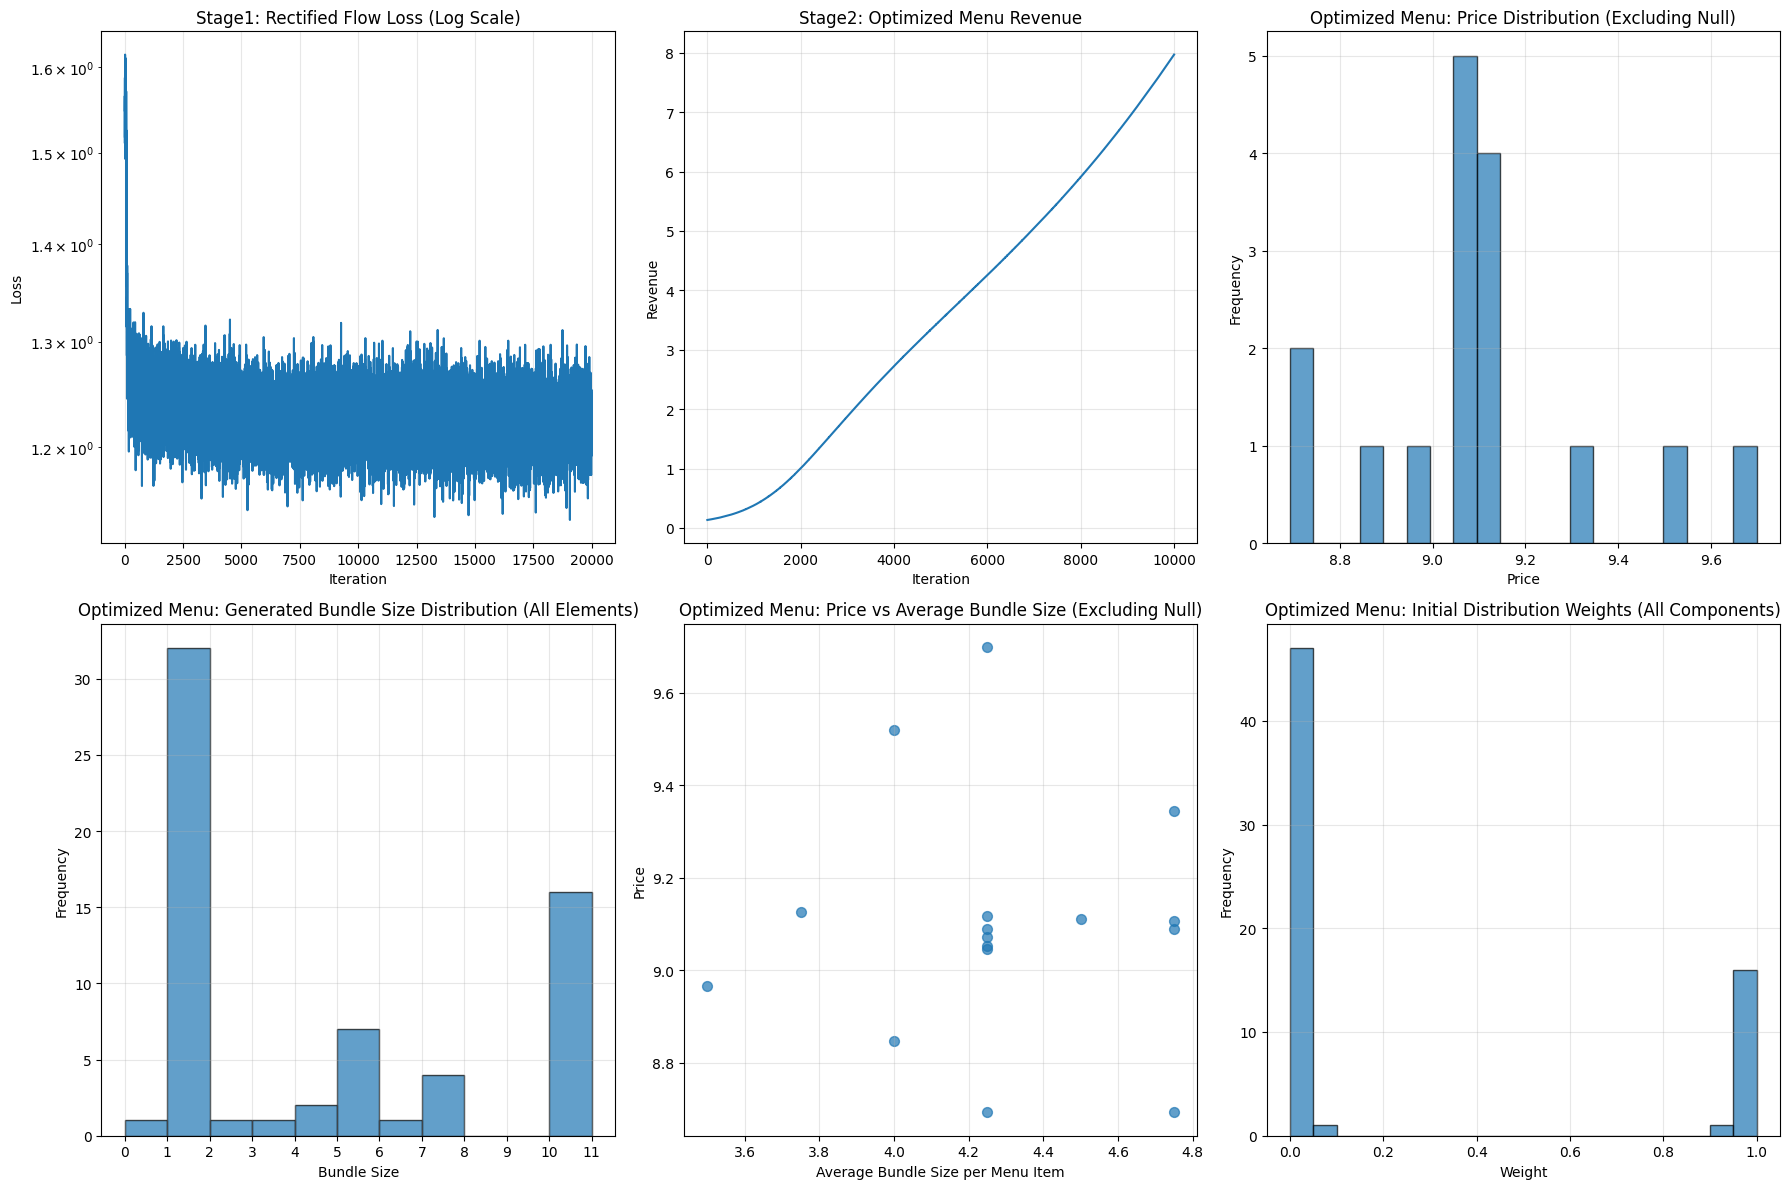


📊 Summary Statistics for Visualized Menu Data:
Prices (excluding null): Min=8.693, Max=9.698, Mean=9.098
Bundle Sizes (all elements): Min=0, Max=10, Mean=4.2
Average Bundle Sizes per Menu Item (excluding null): Min=3.5, Max=4.8, Mean=4.3
Initial Distribution Weights (all components): Min=0.0000, Max=1.0000, Mean=0.2615


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure the necessary variables are available
# losses: from Stage1 training
# revenues_gpu: from Stage2 training
# menu_gpu: the optimized menu from Stage2 training
# flow: the trained flow model (or loaded_flow)
# gpu_config: configuration from Stage2
# stage1_config: configuration from Stage1 (for m and bins)
# device: the device used for tensors

# Check if variables exist and are not None
if 'losses' not in globals() or losses is None:
    print("❌ Error: 'losses' from Stage1 training not found.")
    losses = [] # Use empty list to avoid errors
if 'revenues_gpu' not in globals() or revenues_gpu is None:
    print("❌ Error: 'revenues_gpu' from Stage2 training not found.")
    revenues_gpu = [] # Use empty list to avoid errors
if 'menu_gpu' not in globals() or menu_gpu is None:
    print("❌ Error: 'menu_gpu' from Stage2 training not found.")
    menu_gpu = [] # Use empty list to avoid errors
if 'flow' not in globals() and 'loaded_flow' not in globals():
    print("❌ Error: 'flow' or 'loaded_flow' model not found.")
    flow_model_to_use = None # Use None to indicate no flow model
elif 'loaded_flow' in globals() and loaded_flow is not None:
     flow_model_to_use = loaded_flow # Use loaded flow if available
else:
     flow_model_to_use = flow # Use flow if loaded_flow is not available or None

if 'gpu_config' not in globals():
     print("❌ Error: 'gpu_config' not found.")
     gpu_config = {'ode_steps': 50, 'D': 4, 'm': 10} # Provide minimal default
if 'stage1_config' not in globals():
     print("❌ Error: 'stage1_config' not found.")
     stage1_config = {'m': 10} # Provide minimal default
if 'device' not in globals():
     print("❌ Error: 'device' not found. Using cpu.")
     device = torch.device('cpu') # Default to cpu


# Prepare data for menu visualization
prices = []
bundle_sizes_all = []
avg_sizes = []
weights_flat = []

# Check if menu_gpu is a non-empty list before processing
if isinstance(menu_gpu, list) and len(menu_gpu) > 0:
    # Exclude the null element from price and avg_size calculations
    menu_main_elements = menu_gpu[:-1] if len(menu_gpu) > 1 else menu_gpu # Assume last is null if >1 element

    t_grid = torch.linspace(0.0, 1.0, steps=gpu_config.get('ode_steps', 50), device=device)

    for elem in menu_main_elements:
        if hasattr(elem, 'price'):
            prices.append(elem.price().detach().item())
        if hasattr(elem, 'mus') and hasattr(flow_model_to_use, 'flow_forward') and hasattr(flow_model_to_use, 'round_to_bundle'):
             with torch.no_grad():
                # Process each component of the initial distribution
                mus_item = elem.mus.unsqueeze(0) # Add batch dimension for flow_forward
                try:
                    x_T_item = flow_model_to_use.flow_forward(mus_item.view(-1, gpu_config.get('m', 10)), t_grid)
                    bundles_item = flow_model_to_use.round_to_bundle(x_T_item) # (D, m)
                    sizes_item = bundles_item.sum(dim=1).detach().cpu().numpy() # (D,)
                    bundle_sizes_all.extend(sizes_item)
                    avg_sizes.append(sizes_item.mean())
                except Exception as e:
                    print(f"❌ Error processing menu element for bundle size: {e}")
                    # Continue to the next element if there's an error


        if hasattr(elem, 'weights'):
            weights_flat.extend(elem.weights.detach().cpu().numpy())

    # Include bundles from the null element for total bundle size distribution
    null_element = menu_gpu[-1] if len(menu_gpu) > 0 else None
    if null_element and hasattr(null_element, 'mus') and hasattr(flow_model_to_use, 'flow_forward') and hasattr(flow_model_to_use, 'round_to_bundle'):
         with torch.no_grad():
             null_mu = null_element.mus.unsqueeze(0)
             try:
                 null_x_T = flow_model_to_use.flow_forward(null_mu.view(-1, gpu_config.get('m', 10)), t_grid)
                 null_bundle = flow_model_to_use.round_to_bundle(null_x_T) # (1, m)
                 null_sizes = null_bundle.sum(dim=1).detach().cpu().numpy() # (1,)
                 bundle_sizes_all.extend(null_sizes)
             except Exception as e:
                 print(f"❌ Error processing null element for bundle size: {e}")

    if null_element and hasattr(null_element, 'weights'):
         weights_flat.extend(null_element.weights.detach().cpu().numpy())


# Create the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Stage1 Loss
if losses:
    axes[0, 0].plot(losses)
    axes[0, 0].set_title('Stage1: Rectified Flow Loss (Log Scale)')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)
else:
    axes[0, 0].set_title('Stage1 Loss (No Data)')
    axes[0, 0].text(0.5, 0.5, 'No loss data available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 0].transAxes)


# 2. Stage2 Revenue
if revenues_gpu:
    axes[0, 1].plot(revenues_gpu)
    axes[0, 1].set_title('Stage2: Optimized Menu Revenue')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Revenue')
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].set_title('Stage2 Revenue (No Data)')
    axes[0, 1].text(0.5, 0.5, 'No revenue data available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 1].transAxes)


# 3. Price Distribution
if prices:
    axes[0, 2].hist(prices, bins=20, alpha=0.7, edgecolor='black')
    axes[0, 2].set_title('Optimized Menu: Price Distribution (Excluding Null)')
    axes[0, 2].set_xlabel('Price')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].set_title('Optimized Menu: Price Distribution (No Data)')
    axes[0, 2].text(0.5, 0.5, 'No price data available', horizontalalignment='center', verticalalignment='center', transform=axes[0, 2].transAxes)


# 4. Bundle Size Distribution
if bundle_sizes_all:
    # Determine bins based on item count 'm' from stage1_config, defaulting to 10 if not available
    m_items = stage1_config.get('m', 10)
    axes[1, 0].hist(bundle_sizes_all, bins=range(m_items + 2), alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Optimized Menu: Generated Bundle Size Distribution (All Elements)')
    axes[1, 0].set_xlabel('Bundle Size')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_xticks(range(m_items + 2)) # Ensure ticks for each size
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].set_title('Optimized Menu: Bundle Size Distribution (No Data)')
    axes[1, 0].text(0.5, 0.5, 'No bundle size data available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)


# 5. Price vs Average Bundle Size
if avg_sizes and prices and len(avg_sizes) == len(prices):
    axes[1, 1].scatter(avg_sizes, prices, alpha=0.7, s=50)
    axes[1, 1].set_xlabel('Average Bundle Size per Menu Item')
    axes[1, 1].set_ylabel('Price')
    axes[1, 1].set_title('Optimized Menu: Price vs Average Bundle Size (Excluding Null)')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].set_title('Optimized Menu: Price vs Avg Bundle Size (No Data)')
    axes[1, 1].text(0.5, 0.5, 'Not enough data for scatter plot', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)


# 6. Initial Distribution Weights Distribution
if weights_flat:
    axes[1, 2].hist(weights_flat, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 2].set_title('Optimized Menu: Initial Distribution Weights (All Components)')
    axes[1, 2].set_xlabel('Weight')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 2].set_title('Optimized Menu: Initial Weights (No Data)')
    axes[1, 2].text(0.5, 0.5, 'No weight data available', horizontalalignment='center', verticalalignment='center', transform=axes[1, 2].transAxes)


plt.tight_layout()
plt.show()

# Print summary statistics for verification
print("\n📊 Summary Statistics for Visualized Menu Data:")
if prices:
    print(f"Prices (excluding null): Min={np.min(prices):.3f}, Max={np.max(prices):.3f}, Mean={np.mean(prices):.3f}")
else:
    print("No price data for summary.")

if bundle_sizes_all:
    print(f"Bundle Sizes (all elements): Min={np.min(bundle_sizes_all):.0f}, Max={np.max(bundle_sizes_all):.0f}, Mean={np.mean(bundle_sizes_all):.1f}")
else:
     print("No bundle size data for summary.")

if avg_sizes:
    print(f"Average Bundle Sizes per Menu Item (excluding null): Min={np.min(avg_sizes):.1f}, Max={np.max(avg_sizes):.1f}, Mean={np.mean(avg_sizes):.1f}")
else:
     print("No average bundle size data for summary.")

if weights_flat:
    print(f"Initial Distribution Weights (all components): Min={np.min(weights_flat):.4f}, Max={np.max(weights_flat):.4f}, Mean={np.mean(weights_flat):.4f}")
else:
    print("No initial weight data for summary.")


## Summary:

### Data Analysis Key Findings

*   Saving and loading the trained `flow` model state dictionary and the optimized `menu` (containing custom classes) was successful, requiring `weights_only=False` during menu loading.
*   The loaded `flow` model state dictionary was successfully applied to a new `BundleFlow` instance.
*   The loaded `menu` was verified by inspecting the price/beta of the first and last elements.
*   400 test valuation functions were generated to evaluate the mechanism's performance.
*   A `Mechanism` instance was successfully created using the loaded flow model and menu.
*   The expected revenue using soft assignment on test valuations was calculated as approximately 7.9691.
*   Performance metrics using hard assignment (`argmax`) on test valuations showed approximately 0.0000 revenue, 0.0000 average welfare, and a 1.0000 IR constraint satisfaction rate.
*   Detailed analysis of hard assignment for example valuations revealed that the null element was consistently chosen, resulting in zero utility, price, and welfare for those examples.
*   Visualizations were successfully generated for the Stage 1 loss, Stage 2 revenue, menu price distribution, generated bundle size distribution, price vs. average bundle size, and initial distribution weights.
*   Summary statistics confirmed the data used for visualizations (e.g., prices, bundle sizes, weights).

### Insights or Next Steps

*   The stark difference between soft assignment revenue (\$7.9691) and hard assignment revenue (\$0.0000) suggests a potential issue with the hard assignment rule or the training objective's alignment with hard assignment performance. Further investigation into why the null bundle is consistently chosen under hard assignment is needed.
*   Explore alternative hard assignment rules or modify the training process to better align with hard assignment outcomes if hard assignment is the desired deployment mechanism.
